<a href="https://colab.research.google.com/github/lazysimon/NYCDSA_CapstoneProject/blob/master/movies_knn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import time

# data science imports
import math
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from urllib.request import urlopen

# utils import
!pip install fuzzywuzzy
from fuzzywuzzy import fuzz

# visualization imports
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [0]:
def read_the_dat(filepath):
    with urlopen(filepath) as raw_data:
        datfileL=pd.DataFrame(l.decode("utf-8").rstrip().split('::') for l in raw_data)
    return datfileL

In [3]:
movie_fname = 'https://raw.githubusercontent.com/lazysimon/NYCDSA_CapstoneProject/master/latest/movies.dat'
df_movies = read_the_dat(movie_fname)
df_movies.columns = ['movieID', 'title', 'genres']
df_movies['movieID'] = df_movies['movieID'].astype(int)
df_movies.head()

,movieID,title,genres
0,8,Edison Kinetoscopic Record of a Sneeze (1894),Documentary|Short
1,10,La sortie des usines Lumière (1895),Documentary|Short
2,12,The Arrival of a Train (1896),Documentary|Short
3,25,The Oxford and Cambridge University Boat Race ...,
4,91,Le manoir du diable (1896),Short|Horror


In [4]:
rating_fname = 'https://raw.githubusercontent.com/lazysimon/NYCDSA_CapstoneProject/master/latest/ratings.dat'
df_ratings = read_the_dat(rating_fname)
df_ratings.columns = ['userID', 'movieID', 'rating', 'timestamp']
df_ratings['userID'] = df_ratings['userID'].astype(int)
df_ratings['movieID'] = df_ratings['movieID'].astype(int)
df_ratings['rating'] = df_ratings['rating'].astype(int)
df_ratings['timestamp'] = df_ratings['timestamp'].astype(int)
df_ratings.head()

,userID,movieID,rating,timestamp
0,1,111161,10,1373234211
1,1,117060,7,1373415231
2,1,120755,6,1373424360
3,1,317919,6,1373495763
4,1,454876,10,1373621125


In [6]:
len(df_ratings.userID.unique())

59168

In [0]:
rating_tmp = pd.DataFrame(rating_df.groupby('rating').size(), columns=['count'])
rating_tmp.hist()

In [17]:

# get count
df_ratings_cnt_tmp = pd.DataFrame(df_ratings.groupby('rating').size(), columns=['count'])
df_ratings_cnt_tmp

,count
rating,
0,237
1,9533
2,8213
3,13695
4,25105
5,60047
6,105219
7,180688
8,193298


In [10]:
num_users = len(df_ratings.userID.unique())
num_items = len(df_ratings.movieID.unique())
print('There are {} unique users and {} unique movies in this data set'.format(num_users, num_items))

There are 59168 unique users and 33999 unique movies in this data set


In [12]:
# there are a lot more counts in rating of zero
total_cnt = num_users * num_items
rating_zero_cnt = total_cnt - df_ratings.shape[0]
# append counts of zero rating to df_ratings_cnt
df_ratings_cnt = df_ratings_cnt_tmp.append(
    pd.DataFrame({'count': rating_zero_cnt}, index=[0.0]),
    verify_integrity=True,
).sort_index()
df_ratings_cnt

ValueError: ignored

In [20]:
# add log count
df_ratings_cnt = df_ratings_cnt_tmp.copy()
df_ratings_cnt['log_count'] = np.log(df_ratings_cnt['count'])
df_ratings_cnt

,count,log_count
rating,,
0,237,5.468060
1,9533,9.162515
2,8213,9.013474
3,13695,9.524786
4,25105,10.130822
5,60047,11.002883
6,105219,11.563799
7,180688,12.104527
8,193298,12.171988


Text(0, 0.5, 'number of ratings')

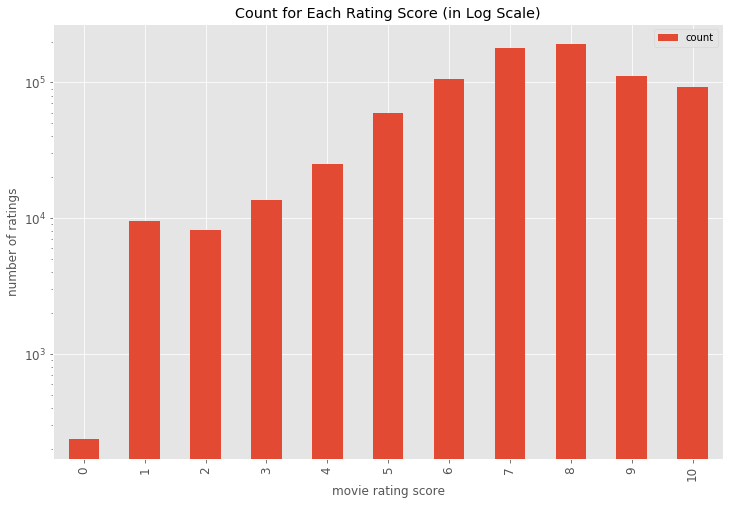

In [22]:
ax = df_ratings_cnt[['count']].reset_index().rename(columns={'rating': 'rating score'}).plot(
    x='rating score',
    y='count',
    kind='bar',
    figsize=(12, 8),
    title='Count for Each Rating Score (in Log Scale)',
    logy=True,
    fontsize=12,
)
ax.set_xlabel("movie rating score")
ax.set_ylabel("number of ratings")

In [23]:
df_ratings.head()

,userID,movieID,rating,timestamp
0,1,111161,10,1373234211
1,1,117060,7,1373415231
2,1,120755,6,1373424360
3,1,317919,6,1373495763
4,1,454876,10,1373621125


In [28]:
# get rating frequency
df_movies_cnt = pd.DataFrame(df_ratings.groupby('movieID').size(), columns=['count'])
df_movies_cnt.head(20)

,count
movieID,
8,1
10,1
12,1
25,1
91,3
131,1
417,22
439,6
443,1


Text(0, 0.5, 'number of ratings')

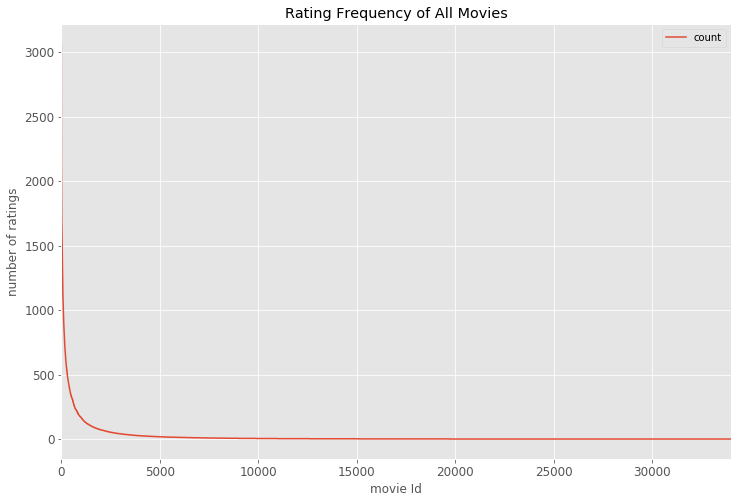

In [29]:

# plot rating frequency of all movies
ax = df_movies_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Movies',
        fontsize=12
    )
ax.set_xlabel("movie Id")
ax.set_ylabel("number of ratings")

Text(0, 0.5, 'number of ratings (log scale)')

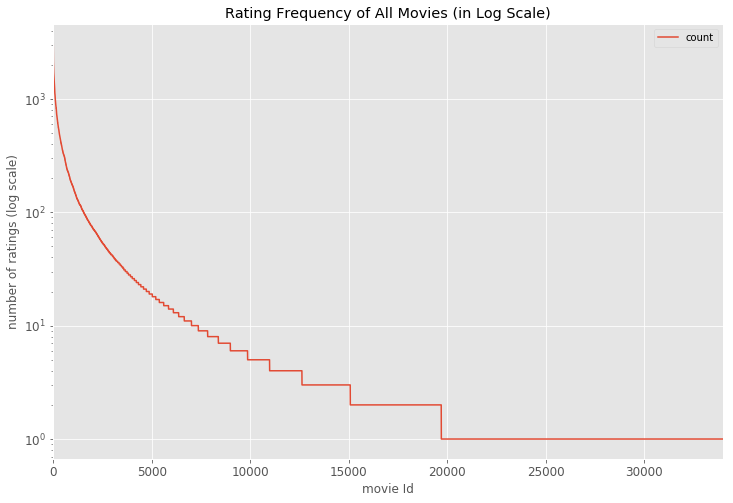

In [30]:

# plot rating frequency of all movies in log scale
ax = df_movies_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Movies (in Log Scale)',
        fontsize=12,
        logy=True
    )
ax.set_xlabel("movie Id")
ax.set_ylabel("number of ratings (log scale)")

In [32]:
df_movies_cnt['count'].quantile(np.arange(1, 0.1, -0.05))

1.00    3065.0
0.95      89.0
0.90      34.0
0.85      18.0
0.80      11.0
0.75       7.0
0.70       5.0
0.65       4.0
0.60       3.0
0.55       2.0
0.50       2.0
0.45       2.0
0.40       1.0
0.35       1.0
0.30       1.0
0.25       1.0
0.20       1.0
0.15       1.0
Name: count, dtype: float64

In [82]:

# filter data
popularity_thres = 8
popular_movies = list(set(df_movies_cnt.query('count >= @popularity_thres').index))
df_ratings_drop_movies = df_ratings[df_ratings.movieID.isin(popular_movies)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping unpopular movies: ', df_ratings_drop_movies.shape)

shape of original ratings data:  (801291, 4)
shape of ratings data after dropping unpopular movies:  (748708, 4)


In [37]:
# get number of ratings given by every user
df_users_cnt = pd.DataFrame(df_ratings_drop_movies.groupby('userID').size(), columns=['count'])
df_users_cnt.head()

,count
userID,
1,19
2,23
3,3
4,1
5,2


Text(0, 0.5, 'number of ratings')

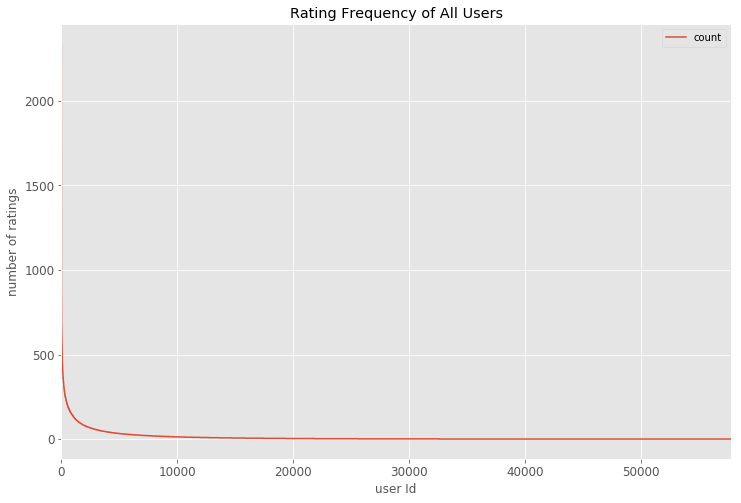

In [39]:

# plot rating frequency of all movies
ax = df_users_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Users',
        fontsize=12
    )
ax.set_xlabel("user Id")
ax.set_ylabel("number of ratings")

In [40]:
df_users_cnt['count'].quantile(np.arange(1, 0.5, -0.05))

1.00    2336.0
0.95      59.0
0.90      29.0
0.85      17.0
0.80      11.0
0.75       8.0
0.70       6.0
0.65       4.0
0.60       3.0
0.55       2.0
Name: count, dtype: float64

In [81]:
# filter data
ratings_thres = 10
active_users = list(set(df_users_cnt.query('count >= @ratings_thres').index))
df_ratings_drop_users = df_ratings_drop_movies[df_ratings_drop_movies.userID.isin(active_users)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping both unpopular movies and inactive users: ', df_ratings_drop_users.shape)

shape of original ratings data:  (801291, 4)
shape of ratings data after dropping both unpopular movies and inactive users:  (659658, 4)


In [43]:
df_ratings_drop_users.head(5)

,userID,movieID,rating,timestamp
0,1,111161,10,1373234211
1,1,117060,7,1373415231
2,1,120755,6,1373424360
3,1,317919,6,1373495763
4,1,454876,10,1373621125


In [0]:

# pivot and create movie-user matrix
movie_user_mat = df_ratings_drop_users.pivot(index='movieID', columns='userID', values='rating').fillna(0)
# create mapper from movie title to index
movie_to_idx = {
    movie: i for i, movie in 
    enumerate(list(df_movies.set_index('movieID').loc[movie_user_mat.index].title))
}
# transform matrix to scipy sparse matrix
movie_user_mat_sparse = csr_matrix(movie_user_mat.values)

In [102]:
%env JOBLIB_TEMP_FOLDER=/tmp
# define model
model_knn = NearestNeighbors(metric='euclidean', algorithm='brute', n_neighbors=10, n_jobs=-1)
# fit
model_knn.fit(movie_user_mat_sparse)

env: JOBLIB_TEMP_FOLDER=/tmp


NearestNeighbors(algorithm='brute', leaf_size=30, metric='euclidean',
                 metric_params=None, n_jobs=-1, n_neighbors=10, p=2,
                 radius=1.0)

In [0]:
def fuzzy_matching(mapper, fav_movie, verbose=True):
    """
    return the closest match via fuzzy ratio. If no match found, return None
    
    Parameters
    ----------    
    mapper: dict, map movie title name to index of the movie in data

    fav_movie: str, name of user input movie
    
    verbose: bool, print log if True

    Return
    ------
    index of the closest match
    """
    match_tuple = []
    # get match
    for title, idx in mapper.items():
        ratio = fuzz.ratio(title.lower(), fav_movie.lower())
        if ratio >= 60:
            match_tuple.append((title, idx, ratio))
    # sort
    match_tuple = sorted(match_tuple, key=lambda x: x[2])[::-1]
    if not match_tuple:
        print('Oops! No match is found')
        return
    if verbose:
        print('Found possible matches in our database: {0}\n'.format([x[0] for x in match_tuple]))
    return match_tuple[0][1]
  
def make_recommendation(model_knn, data, mapper, fav_movie, n_recommendations):
    """
    return top n similar movie recommendations based on user's input movie


    Parameters
    ----------
    model_knn: sklearn model, knn model

    data: movie-user matrix

    mapper: dict, map movie title name to index of the movie in data

    fav_movie: str, name of user input movie

    n_recommendations: int, top n recommendations

    Return
    ------
    list of top n similar movie recommendations
    """
    # fit
    model_knn.fit(data)
    # get input movie index
    print('You have input movie:', fav_movie)
    idx = fuzzy_matching(mapper, fav_movie, verbose=True)
    # inference
    print('Recommendation system start to make inference')
    print('......\n')
    distances, indices = model_knn.kneighbors(data[idx], n_neighbors=n_recommendations+1)
    # get list of raw idx of recommendations
    raw_recommends = \
        sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())), key=lambda x: x[1])[:0:-1]
    # get reverse mapper
    reverse_mapper = {v: k for k, v in mapper.items()}
    # print recommendations
    print('Recommendations for {}:'.format(fav_movie))
    for i, (idx, dist) in enumerate(raw_recommends):
        print('{0}: {1}, with distance of {2}'.format(i+1, reverse_mapper[idx], dist))

In [106]:
my_favorite = 'Titanic'

make_recommendation(
    model_knn=model_knn,
    data=movie_user_mat_sparse,
    fav_movie=my_favorite,
    mapper=movie_to_idx,
    n_recommendations=10)

You have input movie: Titanic
Found possible matches in our database: ['Titanic (1997)']

Recommendation system start to make inference
......

Recommendations for Titanic:
1: Exists (2014), with distance of 48.518037882832814
2: La ciénaga (2001), with distance of 48.48711168960263
3: The Divergent Series: Allegiant (2016), with distance of 48.46648326421054
4: Charlie's Angels: Full Throttle (2003), with distance of 48.4458460551573
5: Highlander II: The Quickening (1991), with distance of 48.373546489791295
6: Wildcats (1986), with distance of 48.062459362791664
7: The Wolfpack (2015), with distance of 48.02082881417188
8: First Man (2018), with distance of 47.853944456021594
9: The Count of Monte Cristo (2002), with distance of 47.22287581247038
10: The Ninth Gate (1999), with distance of 44.05678154382138


In [0]:
def changeencode(data, cols):
    for col in cols:
        data[col] = data[col].str.decode('iso-8859-1').str.encode('utf-8')
    return data  

In [0]:
def read_dat_latin(filepath):
    with urlopen(filepath) as raw_data:
        datfileL=pd.DataFrame(l.decode("latin-1").rstrip().split('::') for l in raw_data)
    return datfileL

In [131]:
mvlens_fname = 'https://github.com/lazysimon/NYCDSA_CapstoneProject/raw/master/ml-1m/movies.dat'
df_mvlens = read_dat_latin(mvlens_fname)
df_mvlens.columns = ['movieID', 'title', 'genres']
df_mvlens['movieID'] = df_mvlens['movieID'].astype(int)
print(df_movies.head())
df_mvlens.head()

   movieID  ...             genres
0        8  ...  Documentary|Short
1       10  ...  Documentary|Short
2       12  ...  Documentary|Short
3       25  ...                   
4       91  ...       Short|Horror

[5 rows x 3 columns]


,movieID,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
